# PROYECTO 1

Boris Castellanos - 201822683  
Carlos Patiño - 201624070  
Joshua Olave - 201821591


## 1. Analisis y descripción de los datos

In [1]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, silhouette_samples, silhouette_score, plot_confusion_matrix
# Regresion lineal
from sklearn.linear_model import LinearRegression

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler


from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#DATABASE LOCATION
df_tracks = pd.read_csv('train.txt', sep=';', names=["Comment", "Feeling"])

#ROWS AND COLUMNS
df_tracks.shape

(16000, 2)

In [3]:
#DISPLAY DATA IN TABLE
display(df_tracks.head(5))

,Comment,Feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
#DATA TYPE DESCRIPTION
df_tracks.dtypes

Comment    object
Feeling    object
dtype: object

In [5]:
#EMPTY DATA
df_porcentajes = (100*df_tracks.isna().sum()/len(df_tracks)).to_frame()
df_porcentajes.sort_values(0, ascending = False)

,0
Comment,0.0
Feeling,0.0


In [6]:
#CHECK FOR NULLS
df_tracks.isnull().sum()

Comment    0
Feeling    0
dtype: int64

In [7]:
#COUNT OF FEELINGS
df_tracks['Feeling'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Feeling, dtype: int64

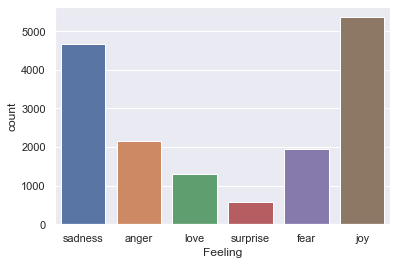

In [8]:
#COUNT OF FEELINGS PLOT
ax = sns.countplot(x='Feeling', data=df_tracks)
plt.show()

## 2. Limpieza y preparación de los datos

In [9]:
#COPY FOR TRANSFORM DATA
df_tracks_t = df_tracks

In [10]:
#MODI
def Feeling (row):
    if row['Feeling'] == 'sadness':
        return 1
    elif row['Feeling'] == 'joy':
        return 2
    elif row['Feeling'] == 'fear':
        return 3
    elif row['Feeling'] == 'anger':
        return 4
    elif row['Feeling'] == 'love':
        return 5
    elif row['Feeling'] == 'surprise':
        return 6
    return 0
df_tracks_t['Feeling'] = df_tracks_t.apply (lambda row: Feeling(row), axis=1)
df_tracks_t.head()

,Comment,Feeling
0,i didnt feel humiliated,1
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,4
3,i am ever feeling nostalgic about the fireplac...,5
4,i am feeling grouchy,4


In [11]:
df_tracks['Feeling'].value_counts()

2    5362
1    4666
4    2159
3    1937
5    1304
6     572
Name: Feeling, dtype: int64

In [12]:
#COPY FOR MODELS
df_tracks_m1 = df_tracks_t

In [13]:
#PREPARE OBJETIVE VARIABLE
Y = df_tracks_m1['Feeling']
X = CountVectorizer().fit_transform(df_tracks_m1['Comment'])

In [14]:
#DIVIDE DATA FOR TEST AND TRAIN
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

## 3. Construcción del modelos

### 3.1. KNN

In [15]:
#DEFINING RANGE OF NEIGHBORS GETTING BEST MODEL
n_vecinos =  list(range(1,11))
param_grid = {'n_neighbors': n_vecinos, 'p': [1, 2]}
clasificadorKNN = KNeighborsClassifier()
modelo_Knn = GridSearchCV(clasificadorKNN, param_grid, cv=particiones)
modelo_Knn.fit(X_train,Y_train) 
print("Mejor parámetro: {}".format(modelo_Knn.best_params_)) 
print("Mejor cross-validation score: {:.2f}".format(modelo_Knn.best_score_))

Mejor parámetro: {'n_neighbors': 8, 'p': 1}
Mejor cross-validation score: 0.43


In [16]:
#RUNNING OVER TEST DATA
modelo_final = modelo_Knn.best_estimator_
y_pred_train = modelo_final.predict(X_train)
y_pred_test = modelo_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.58
Exactitud sobre test: 0.43


In [17]:
#CLASSIFICATION REPOR OVER TEST
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.40      0.75      0.52       905
           2       0.48      0.51      0.50      1053
           3       0.47      0.17      0.25       397
           4       0.45      0.19      0.27       459
           5       0.60      0.08      0.14       271
           6       0.50      0.02      0.03       115

    accuracy                           0.43      3200
   macro avg       0.48      0.29      0.28      3200
weighted avg       0.46      0.43      0.39      3200



In [18]:
#CLASSIFICATION REPOR OVER TRAIN
print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           1       0.50      0.86      0.64      3761
           2       0.63      0.67      0.65      4309
           3       0.70      0.31      0.43      1540
           4       0.67      0.36      0.46      1700
           5       0.78      0.14      0.23      1033
           6       0.84      0.11      0.19       457

    accuracy                           0.58     12800
   macro avg       0.69      0.41      0.43     12800
weighted avg       0.63      0.58      0.54     12800



### 3.2 Árbol de decisión

In [20]:
#CREATION OF TREE, USING K PARTITIONS FOR FIND THE BEST OPTION
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20],'min_samples_split':[2, 3, 4, 5]}
arbol = DecisionTreeClassifier(random_state=0)
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20],
                         'min_samples_split': [2, 3, 4, 5]})

In [ ]:
mejor_modelo.best_params_

In [ ]:
#RUNNING OVER TRAIN AND TEST
arbol_final = mejor_modelo.best_estimator_
y_pred_train = arbol_final.predict(X_train)
y_pred_test = arbol_final.predict(X_test)

In [ ]:
#SHOW CONFUSION MATRIX
plot_confusion_matrix(arbol_final, X_test, Y_test)
plt.show()

In [ ]:
#REPORT
print(classification_report(Y_test, y_pred_test))

### 3.3 Regresion Logistica
